# Задание из четвёртой лабы

Обучите один из алгоритмов классификации из библиотеки sklearn. Объяснять принцип работы классификатора в этой лабораторной не требуется

1. Выберите один из датасетов первой лабораторной


2. Найдите в данных признак, который будете предсказывать
    
    Если это категория, то у неё должно быть от 2 до 10 значений (например колонка species в датасете миграции птиц содержит 3 категории)
    
    Если признак количественный, то его нужно дискретизировать (например для популярности трека в датасете spotify можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку


3. Выделите признаки для предсказания
    
    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной


4. Проверьте нормальность количественных признаков
    
    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность
    
    Как минимум 1 из признаков должен быть нормальным


5. Покажите качество предсказания модели с помощью метрик

    Метрика должна учитывать баланс классов в датасете

In [7]:
# Импорт базовых библиотек
import numpy as np
import pandas as pd

# Визуализация

import seaborn as sns
import matplotlib.pyplot as plt

# Датасеты
# from sklearn.datasets import load_iris  # для классификации
# from sklearn.datasets import load_boston  # для регрессии

# Utils
from sklearn.model_selection import train_test_split, cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Модели (регрессия)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # для классификации
from sklearn.metrics import mean_absolute_error, mean_squared_error  # для регрессии

# Misc
from sklearn.manifold import TSNE

%matplotlib inline

In [8]:
dataset = pd.read_csv("anon_gps_tracks_with_dive.csv")
dataset = dataset.set_index(dataset.iloc[:, 0])
dataset

,Unnamed: 0,lat,lon,alt,unix,bird,species,year,date_time,max_depth.m,colony2,coverage_ratio,is_dive,is_dive_1m,is_dive_2m,is_dive_4m,is_dive_5m,is_dive_0m
Unnamed: 0,,,,,,,,,,,,,,,,,,
1,1,56.095451,-6.233089,-23.059999,1340627854,1,tCOGU,t2012,2012-06-25 13:37:34,-2.172046,1,0.5,False,False,False,False,False,False
2,2,56.095408,-6.233520,-2.983077,1340627954,1,tCOGU,t2012,2012-06-25 13:39:14,-1.152306,1,0.6,False,False,False,False,False,False
3,3,56.095437,-6.234275,3.470286,1340628054,1,tCOGU,t2012,2012-06-25 13:40:54,-2.172046,1,0.7,False,False,False,False,False,False
4,4,56.095635,-6.234815,1.902667,1340628154,1,tCOGU,t2012,2012-06-25 13:42:34,-2.172046,1,0.8,False,False,False,False,False,False
5,5,56.095821,-6.235293,2.824952,1340628254,1,tCOGU,t2012,2012-06-25 13:44:14,-2.172046,1,0.9,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263714,263714,57.380016,-1.876185,38.550566,1339500344,108,tCOGU,t2012,2012-06-12 12:25:44,-1.152306,10,NaN,False,False,False,False,False,False
263715,263715,57.380147,-1.876534,32.490545,1339500444,108,tCOGU,t2012,2012-06-12 12:27:24,-1.152306,10,NaN,False,False,False,False,False,False
263716,263716,57.380096,-1.876400,38.292069,1339500544,108,tCOGU,t2012,2012-06-12 12:29:04,1.906914,10,NaN,False,True,False,False,False,True


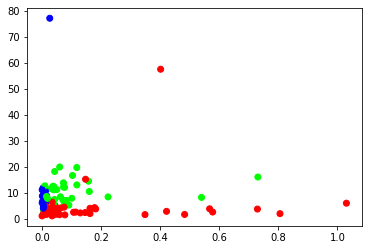

In [9]:
dataset.sort_values(["bird", "unix"], inplace=True)
dataset["dist"] = np.sqrt(dataset["lat"] ** 2 + dataset["lon"] ** 2 + (dataset["max_depth.m"] / 111111) ** 2)
dataset["dpos"] = np.sqrt(dataset["lat"].diff() ** 2 + dataset["lon"].diff() ** 2 + (dataset["max_depth.m"].diff() / 111111) ** 2)
dataset.loc[dataset.bird != dataset.bird.shift(1), "dpos"] = np.nan

groups = dataset.groupby(dataset.bird)
columns = {"depth_med": groups["max_depth.m"].median() - dataset["max_depth.m"].min(),
           "depth_std": groups["max_depth.m"].std(),
           "scatter_std": groups["dist"].std(),
           "speed": groups["dpos"].sum() / groups["dpos"].count()}

X = pd.DataFrame(columns).to_numpy()
columns["target"] = groups["species"].first()
y = columns["target"].to_numpy()
df = pd.DataFrame(columns)
df.reset_index(drop=True, inplace=True)

cmap = {"tRAZO": (1, 0, 0, 1), "tCOGU": (0, 1, 0, 1), "tEUSH": (0, 0, 1, 1)}
plt.scatter(x=df["scatter_std"], y=df["depth_std"], c=list(map(cmap.__getitem__, df.target)));

In [10]:
import scipy.stats
for species in cmap:
    print(species, "depth median:", scipy.stats.normaltest(np.log(df[df.target == species].depth_med))[1])
for species in cmap:
    print(species, "depth std:", scipy.stats.normaltest(df[df.target == species].depth_std)[1])
for species in cmap:
    print(species, "scatter std:", scipy.stats.normaltest(df[df.target == species].scatter_std)[1])
for species in cmap:
    print(species, "speed:", scipy.stats.normaltest(df[df.target == species].speed)[1])

tRAZO depth median: 0.7786771941245625
tCOGU depth median: 0.3766675773939392
tEUSH depth median: 0.9068183273866182
tRAZO depth std: 1.5563374694872417e-28
tCOGU depth std: 0.4588971371004257
tEUSH depth std: 2.8758778218460967e-09
tRAZO scatter std: 3.3823302372534e-11
tCOGU scatter std: 1.8583317595385686e-10
tEUSH scatter std: 0.004401289940985604
tRAZO speed: 1.0836974386392522e-11
tCOGU speed: 0.013272455260199557
tEUSH speed: 0.3121842573613347


c:\users\nh5\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   depth_med    108 non-null    float64
 1   depth_std    108 non-null    float64
 2   scatter_std  108 non-null    float64
 3   speed        108 non-null    float64
 4   target       108 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.3+ KB


,depth_med,depth_std,scatter_std,speed
count,108.000000,108.000000,108.000000,108.000000
mean,9.593487,7.128221,0.108433,0.002415
std,1.292761,9.564728,0.184867,0.004876
min,7.138180,1.099980,0.000331,0.000197
25%,8.922725,2.493081,0.018607,0.000737
50%,9.177660,4.130236,0.040631,0.001108
75%,10.452335,8.702519,0.101530,0.001541
max,14.276360,77.228245,1.030258,0.026627


(array(['tCOGU', 'tEUSH', 'tRAZO'], dtype=object), array([31, 15, 62], dtype=int64))


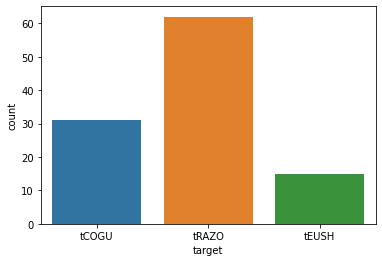

In [12]:
print(np.unique(df.target, return_counts=True))
sns.countplot(x='target', data=df);

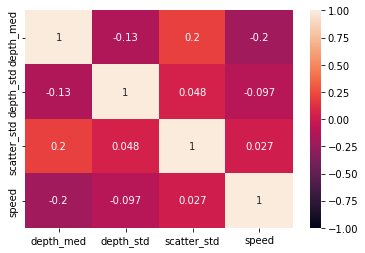

In [13]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

In [14]:
"""

# Попробуем описать имеющиеся данные в пространстве меньшей размерности
from sklearn.decomposition import PCA

X_embedded = PCA(n_components=2, random_state=30).fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

ax.set_title('Dataset representation', fontsize=15)
ax.set_xlabel('Feature 1', fontsize=15)
ax.set_ylabel('Feature 2', rotation=0, labelpad=30, fontsize=15)
ax.grid()

sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=df.target,
    ax=ax
)

df2 = pd.DataFrame({"Feature 1": X_embedded[:, 0], "Feature 2": X_embedded[:, 1], "target": y})
"""
df2 = df
X_embedded = X

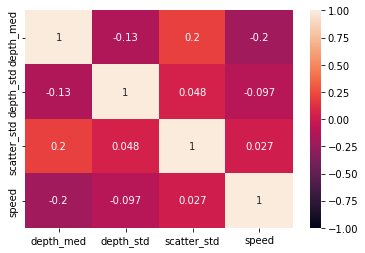

In [15]:
sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True);

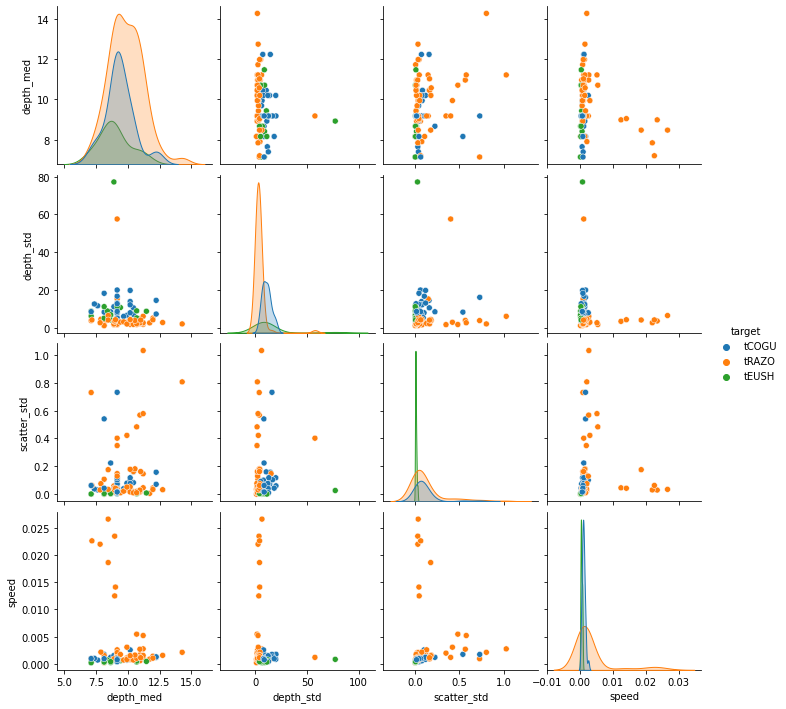

In [16]:
sns.pairplot(df2, hue='target');

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, shuffle=True, stratify=y, test_size=0.2)

# Инициализируем алгоритмы с параметрами по-умолчанию
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

# Посчитаем метрику качества используя кросс-валидацию
scorer = make_scorer(balanced_accuracy_score)
knn_acc_score = cross_val_score(knn_clf, X, y, cv=7, scoring=scorer).mean()
svm_acc_score = cross_val_score(svm_clf, X, y, cv=7, scoring=scorer).mean()
forest_acc_score = cross_val_score(forest_clf, X, y, cv=7, scoring=scorer).mean()

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. Forest: 0.7794973544973544
2. KNN: 0.5904761904761905
3. SVC: 0.5834656084656084


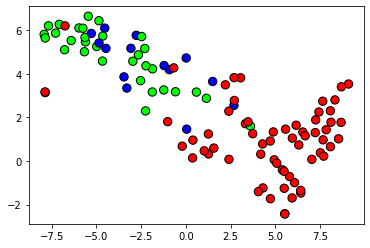

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(X_embedded)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=list(map(cmap.__getitem__, df.target)), s=70, edgecolor='k')
plt.show()

In [19]:
"""
import umap

reducer = umap.UMAP(n_neighbors=3, min_dist = 0.2, random_state=42)
reducer.fit(digits.data)
X_reduced = reducer.transform(digits.data)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, edgecolor='k', cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.show()
"""

c:\users\nh5\appdata\local\programs\python\python39\python.exe


AttributeError: module 'umap' has no attribute 'UMAP'

Intracluster distance: 2.6901382900994784
Intercluster distance: 8.825488420795175


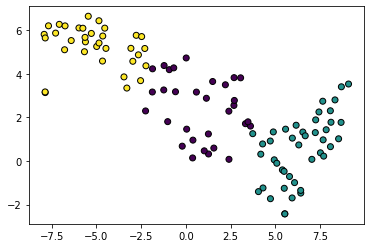

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

kmeans = KMeans(n_clusters = 3, random_state = 0).fit(X_reduced)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_, edgecolor='k')
df = pd.DataFrame(X_reduced)

def trf(x):
    res = euclidean_distances(x)
    return np.sum(res) / (res.shape[0] * (res.shape[0] - 1))

dfgr = df.groupby(kmeans.labels_)
print('Intracluster distance:', dfgr.apply(trf).mean())

dfgrnp = dfgr.apply(lambda x: x.to_numpy())

print('Intercluster distance:', sum(sum(0 if i == j else np.sum(euclidean_distances(dfgrnp[i], dfgrnp[j]))
        for j in range(len(dfgrnp)))
    for i in range(len(dfgrnp))) /\
    sum(len(g) * (len(X_reduced) - len(g)) for g in dfgrnp))